# Task 1: Image Sharpening and Edge Detection
* Select a blurry image (either captured or obtained online).
* Apply sharpening techniques such as:
	* Unsharp Masking
	* High-pass Filtering
	* Laplacian Filtering

In [41]:
# Import packages
import numpy as np
import matplotlib.pylab as plt
from skimage.io import imread
from skimage.filters import unsharp_mask
import cv2

In [85]:
# Load the image
image_path = "menorah_cropped.png"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

In [86]:
# Apply Unsharp Masking
gaussian_blur = cv2.GaussianBlur(image, (9, 9), 10.0)
unsharp_mask = cv2.addWeighted(image, 1.5, gaussian_blur, -0.5, 0)

In [92]:
# Apply Sobel Filter(High-Pass)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # Convert to gray

# Calculate gradients using Sobel operator
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the absolute gradient magnitude
abs_grad_x = cv2.convertScaleAbs(sobelx)
abs_grad_y = cv2.convertScaleAbs(sobely)
grad = cv2.addWeighted(abs_grad_x, 1, abs_grad_y, 1, 0)

# Sharpen the image by adding the gradient magnitude to the original image
high_pass = cv2.addWeighted(image, 1, grad, 1, 0)

# Apply Laplacian Filter
#laplacian = cv2.Laplacian(gray, cv2.CV_64F)
#laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX)
#laplacian = np.uint8(laplacian)
#laplacian = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2RGB)

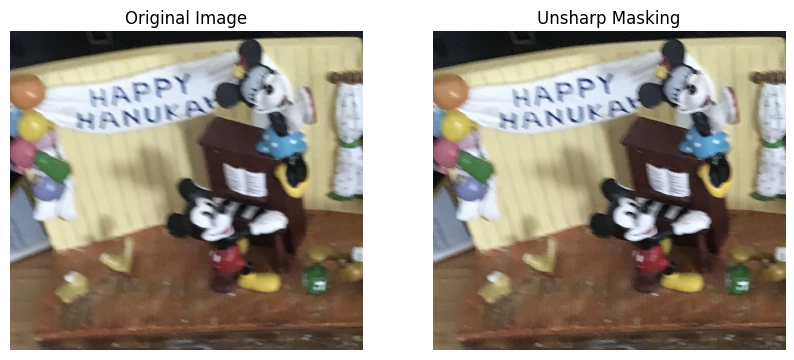

In [118]:
# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[1].imshow(unsharp_mask)
axes[1].set_title("Unsharp Masking")


for ax in axes:
    ax.axis("off")

plt.show()

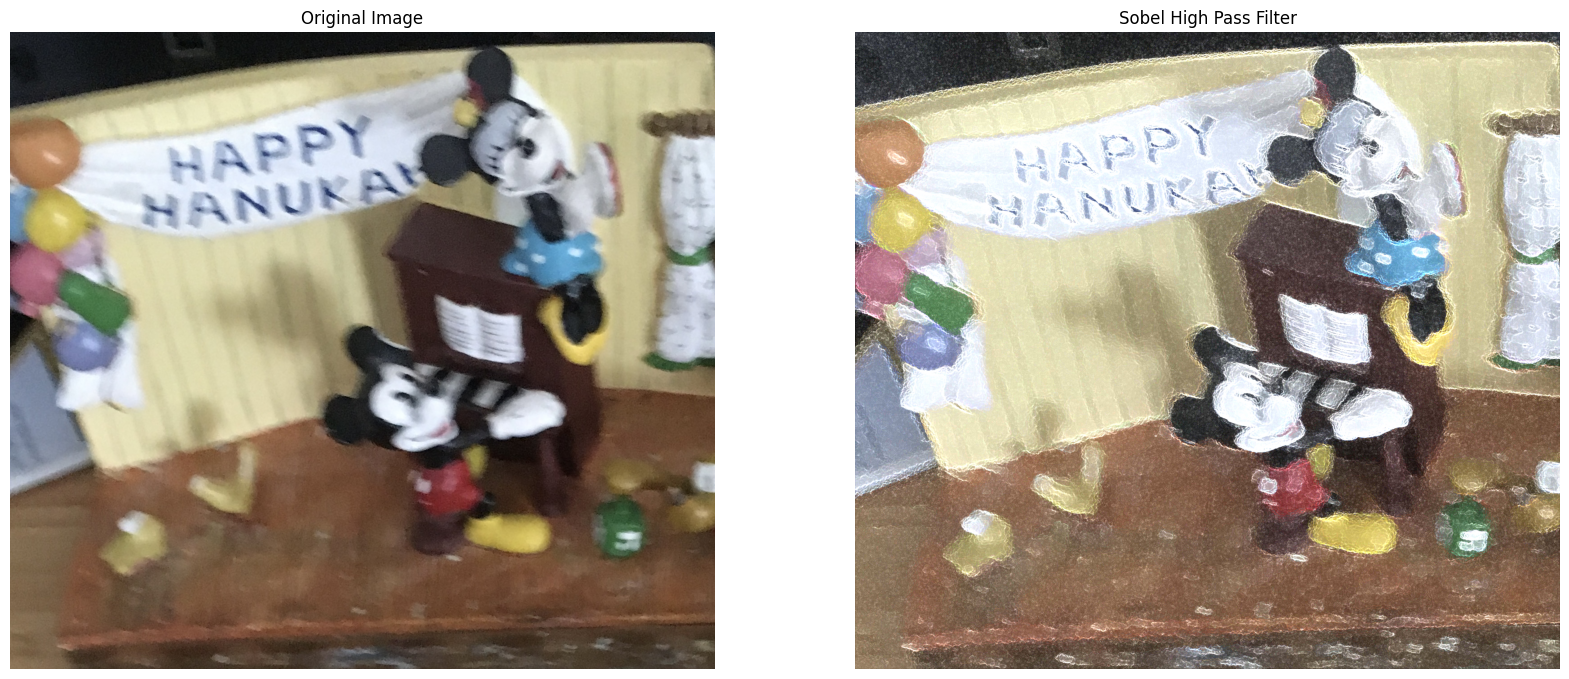

In [117]:
# Display results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[1].imshow(high_pass)
axes[1].set_title("Sobel High Pass Filter")

for ax in axes:
    ax.axis("off")
plt.show()

Comparing the original photo to the Sobel High Pass filter:
  * The sobel filter makes horizontal and vertical lines clearer, but makes rounded edges more blurry.

**Sub-task 1: Edge Detection**

* Apply an edge detection method of your choice (e.g., Sobel, Canny) to:
	* The original blurry image.
	* The sharpened image.
	* The image after adding artificial noise (Gaussian or salt-and-pepper noise).
* Provide a visual comparison of the edge maps.

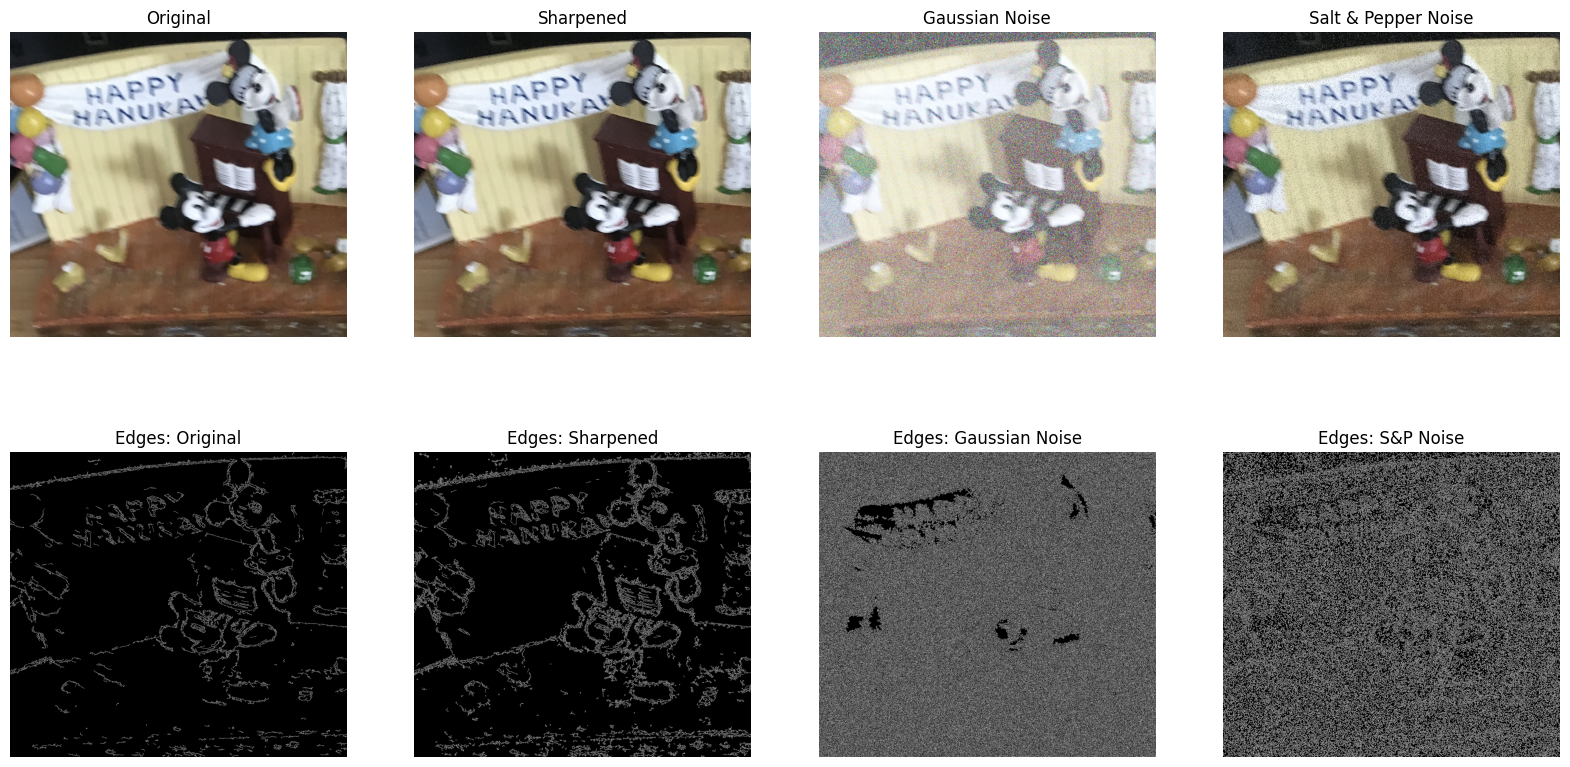

In [119]:
# Add Gaussian Noise
g_noise = image.copy()
mean = 0
stddev = 25  # Adjust noise level
gaussian_noise = np.random.normal(mean, 5, image.shape).astype(np.uint8)
g_noise = cv2.add(image, gaussian_noise)

# Add Salt-and-Pepper Noise
def salt_and_pepper(img, prob=0.02):
    noisy = img.copy()
    total_pixels = img.size
    num_salt = int(prob * total_pixels / 2)
    num_pepper = int(prob * total_pixels / 2)

    # Add salt (white) noise
    coords = [np.random.randint(0, i, num_salt) for i in img.shape]
    noisy[coords[0], coords[1]] = 255

    # Add pepper (black) noise
    coords = [np.random.randint(0, i, num_pepper) for i in img.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy

sp_noise = salt_and_pepper(image)

# Apply Canny Edge Detection
edges_original = cv2.Canny(image, 50, 150)
edges_sharpened = cv2.Canny(unsharp_mask, 50, 150)
edges_gaussian_noise = cv2.Canny(g_noise, 50, 150)
edges_sp_noise = cv2.Canny(sp_noise, 50, 150)

# Display the results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
images = [image, unsharp_mask, g_noise, sp_noise,
          edges_original, edges_sharpened, edges_gaussian_noise, edges_sp_noise]
titles = ["Original", "Sharpened", "Gaussian Noise", "Salt & Pepper Noise",
          "Edges: Original", "Edges: Sharpened", "Edges: Gaussian Noise", "Edges: S&P Noise"]

for ax, img, title in zip(axes.ravel(), images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis("off")

plt.show()


**Sub-task 2: Performance Analysis**
* Comment on how sharpening affects edge detection.
  * Sharpening the image improves edge detection. The edges of mickey, minnie, music sheet, and words on the banner are much clearer in the sharpened photo.
* Discuss how noise impacts the edge detector’s performance.
  * Adding noise decreases the edge detectors performance because the intensity values are being blurred.

# Task 2: Hybrid Images (Reference Paper: Oliva and Torralba (2006))
* Select two images of two of your favorite actors.
* Convert both images to grayscale and align them.
* Apply frequency decomposition:
	* Low-pass filter one image using a Gaussian filter.
	* High-pass filter the second image by subtracting its Gaussian-blurred version from
the original.
	* Combine the two filtered images to create the hybrid image.
* Experiment with different cutoff frequencies to get the best hybrid effect.
* Visualize the frequency components by computing and displaying:
	* The log magnitude of the Fourier transform of the two input images.
	* The filtered images.
	* The hybrid image.
* Try generating 2-3 hybrid images with different combinations (e.g., facial expressions,
object morphing).

In [ ]:
# Install dlib package and facial landmark detector
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

import cv2
import numpy as np
import dlib
from scipy.spatial import Delaunay
import numpy as np
from google.colab.patches import cv2_imshow

In [121]:
# Load pre-trained facial landmark detector from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Download from dlib

# Load input images
img1 = cv2.imread("ryan_gosling.jpg")
img2 = cv2.imread("margot_robbie.jpg")

Get face landmarks using dlib

In [132]:
# Function for getting coordinates of facial landmarks
def get_facial_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to gray
    faces = detector(gray) # Apply face detector

    if len(faces) == 0: # Error handling
        raise ValueError("No faces detected!")

    # Get shapes & coordinates of landmarks
    shape = predictor(gray, faces[0])
    points = [(shape.part(i).x, shape.part(i).y) for i in range(68)] # Get x, y coordinaets of shape

    return np.array(points, dtype=np.int32)

# Function for affine transformation
def apply_affine_transform(src, src_tri, dst_tri, size):
    """Applies an affine transformation to warp a triangular region."""
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    return cv2.warpAffine(src, warp_mat, (size[0], size[1]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

# Function to warp triangles using affine transformation
def warp_triangle(img1, img2, tri1, tri2):
    #get bounding boxes
    rect1 = cv2.boundingRect(np.float32([tri1]))
    rect2 = cv2.boundingRect(np.float32([tri2]))

    # calculate triangles
    tri1_rect = [(t[0] - rect1[0], t[1] - rect1[1]) for t in tri1]
    tri2_rect = [(t[0] - rect2[0], t[1] - rect2[1]) for t in tri2]

    mask = np.zeros((rect2[3], rect2[2], 3), dtype=np.float32) # create mask

    img1_cropped = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]] # crop image 1
    warped_img = apply_affine_transform(img1_cropped, tri1_rect, tri2_rect, (rect2[2], rect2[3])) # apply affine transformation

    mask_tri = np.zeros((rect2[3], rect2[2]), dtype=np.uint8) # create triangle mask
    cv2.fillConvexPoly(mask_tri, np.int32(tri2_rect), 255) # create shape

    img2_crop = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] # repeat abobve steps
    img2_crop = img2_crop.astype(np.float32)

    warped_img = warped_img * (mask_tri[..., np.newaxis] / 255.0) + img2_crop * (1 - mask_tri[..., np.newaxis] / 255.0)

    img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] = warped_img.astype(np.uint8)

# Function to create the hybrid image using delanany triangles
def hybrid_image(img1, img2, points1, points2, sigma=10):
    tri = Delaunay(points1) # get delanany triangulation for points
    img2 = img2.copy()

    for simplex in tri.simplices: #get coordinates to warp
        tri1 = [points1[i] for i in simplex]
        tri2 = [points2[i] for i in simplex]
        warp_triangle(img1, img2, tri1, tri2)

    # Low-pass filter (Gaussian blur)
    low_pass = cv2.GaussianBlur(img1, (2 * sigma + 1, 2 * sigma + 1), sigma)

    # High-pass filter (original - blurred)
    img1_blur = cv2.GaussianBlur(img2, (2 * sigma + 1, 2 * sigma + 1), sigma)
    high_pass = cv2.subtract(img2, img1_blur)

    # Combine high-pass and low-pass filtered images
    hybrid_result = cv2.addWeighted(low_pass, 1,high_pass, 1, 0)

    return hybrid_result

In [165]:
# Load images
img1 = cv2.imread("ryan_gosling.jpg")
img2 = cv2.imread("margot_robbie.jpg")

# Resize images to the same size
h, w = img2.shape[:2]  # Use image2's size as reference
img1 = cv2.resize(img1, (w, h))

# Detect facial landmarks
points1 = get_facial_landmarks(img1)
points2 = get_facial_landmarks(img2)

# Generate hybrid image
hybrid_result = hybrid_image(img1, img2, points1, points2)

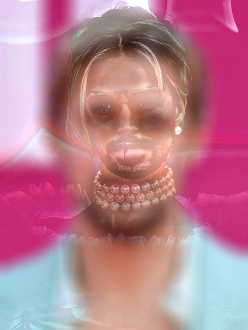

In [134]:
# Save and display
cv2.imwrite("hybrid_image.jpg", hybrid_result)
cv2_imshow( hybrid_result)

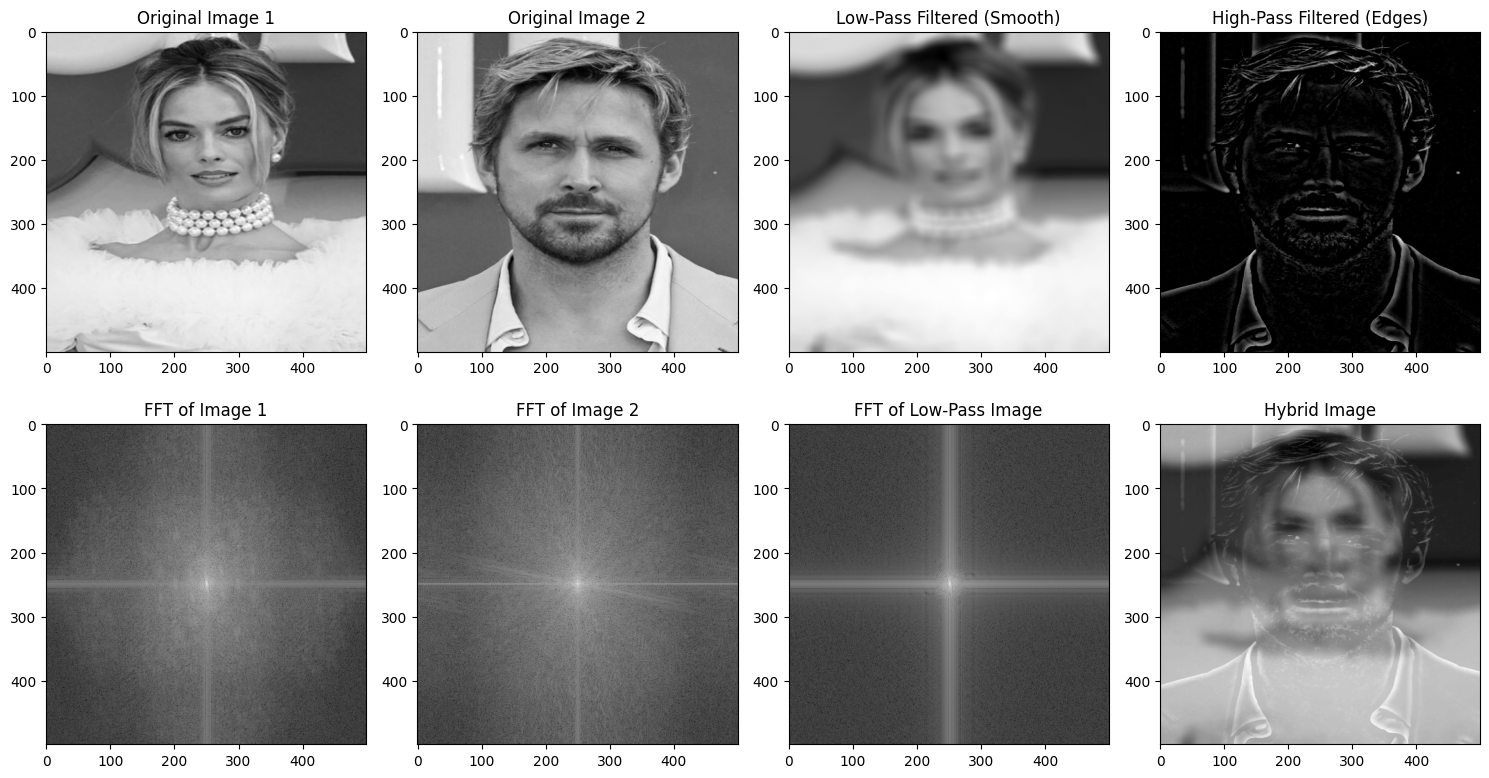

True

In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess(img1_path, img2_path, size=(500, 500)):
    """Loads, resizes, and converts images to grayscale."""
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    img1 = cv2.resize(img1, size)
    img2 = cv2.resize(img2, size)

    return img1, img2

def apply_frequency_decomposition(img1, img2, sigma=10):
    """Applies Gaussian low-pass and high-pass filtering."""
    low_pass = cv2.GaussianBlur(img1, (2 * sigma + 1, 2 * sigma + 1), sigma)

    img2_blur = cv2.GaussianBlur(img2, (2 * sigma + 1, 2 * sigma + 1), sigma)
    high_pass = cv2.subtract(img2, img2_blur)

    hybrid = cv2.addWeighted(low_pass, 0.5, high_pass, 0.5, 0)

    return low_pass, high_pass, hybrid

def compute_fft(image):
    """Computes the log magnitude of the Fourier transform."""
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    magnitude = 20 * np.log(np.abs(dft_shift) + 1)
    return magnitude

def visualize_results(img1, img2, low_pass, high_pass, hybrid):
    """Displays the images, frequency spectrums, and results."""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title("Original Image 1")

    axes[0, 1].imshow(img2, cmap='gray')
    axes[0, 1].set_title("Original Image 2")

    axes[0, 2].imshow(low_pass, cmap='gray')
    axes[0, 2].set_title("Low-Pass Filtered (Smooth)")

    axes[0, 3].imshow(high_pass, cmap='gray')
    axes[0, 3].set_title("High-Pass Filtered (Edges)")

    axes[1, 0].imshow(compute_fft(img1), cmap='gray')
    axes[1, 0].set_title("FFT of Image 1")

    axes[1, 1].imshow(compute_fft(img2), cmap='gray')
    axes[1, 1].set_title("FFT of Image 2")

    axes[1, 2].imshow(compute_fft(low_pass), cmap='gray')
    axes[1, 2].set_title("FFT of Low-Pass Image")

    axes[1, 3].imshow(hybrid, cmap='gray')
    axes[1, 3].set_title("Hybrid Image")

    plt.tight_layout()
    plt.show()

# Load images
img1, img2 = load_and_preprocess("margot_robbie.jpg", "ryan_gosling.jpg")

# Apply frequency decomposition
low_pass, high_pass, hybrid = apply_frequency_decomposition(img1, img2, sigma=10)

# Visualize results
visualize_results(img1, img2, low_pass, high_pass, hybrid)

# Save the hybrid image
cv2.imwrite("hybrid_image.jpg", hybrid)


I tried to build my own process for face morphing below. I manually labelled 43 points on each celeberties face and extracted the x,y coordinate. Then I built my own morphing functions. I was inspired by this resource: https://courses.grainger.illinois.edu/cs498dh3/fa2012/projects/morphing/ComputationalPhotography_ProjectMorphing.html

I tried to label these points on the celeberties faces: https://courses.grainger.illinois.edu/cs498dh3/fa2012/projects/morphing/efros_points.jpg

This is the order for the landmarks: https://courses.grainger.illinois.edu/cs498dh3/fa2012/projects/morphing/efros_point_numbers.jpg

The cell below contains the x, y coordinates for both faces in 'mr_points' and 'rg_points'

In [161]:
# @title
mr_points = np.array([[131, 176]
,[106, 167]
,[97, 155 ]
,[85, 130 ]
,[86, 103 ]
,[88, 70  ]
,[109, 56 ]
,[140, 57 ]
,[158, 73 ]
,[176, 97 ]
,[174, 125]
,[171, 147]
,[156, 165]
,[79, 130 ]
,[72, 113 ]
,[70, 97  ]
,[69, 49  ]
,[91, 19  ]
,[107, 10 ]
,[135, 7  ]
,[171, 25 ]
,[184, 52 ]
,[186, 95 ]
,[185, 111]
,[178, 127]
,[104, 107]
,[147, 103]
,[87, 99  ]
,[100, 96 ]
,[117, 99 ]
,[131, 97 ]
,[147, 90 ]
,[161, 92 ]
,[124, 105]
,[116, 130]
,[126, 130]
,[138, 132]
,[112, 148]
,[128, 143]
,[147, 145]
,[117, 156]
,[129, 158]
,[143, 154]])

rg_points = np.array([[180, 345],
[111, 291 ],
[92, 251 ],
[90, 234 ],
[93, 154 ],
[117, 88 ],
[147, 75 ],
[223, 80 ],
[255, 94 ],
[268, 161],
[269, 237],
[263, 267],
[225, 321],
[75, 228 ],
[64, 196 ],
[67, 169 ],
[71, 93  ],
[106, 38 ],
[149, 14 ],
[237, 30 ],
[287, 73 ],
[297, 103],
[300, 168],
[296, 202],
[278, 237],
[144, 169],
[219, 175],
[119, 159],
[143, 157],
[174, 162],
[185, 164],
[224, 162],
[247, 169],
[183, 174],
[159, 231],
[184, 227],
[207, 229],
[151, 268],
[180, 268],
[208, 270],
[152, 273],
[181, 279],
[206, 274]])

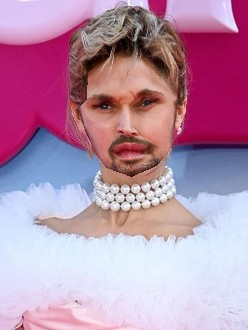

In [166]:
from scipy.spatial import Delaunay
img1 = cv2.imread("ryan_gosling.jpg")
img2 = cv2.imread("margot_robbie.jpg")

def apply_affine_transform(src, src_tri, dst_tri, size):
    """Applies an affine transform to warp a triangular region."""
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    return cv2.warpAffine(src, warp_mat, (size[0], size[1]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def warp_triangle(img1, img2, tri1, tri2):
    """Warp a single triangle from img1 to img2 using affine transformation."""
    rect1 = cv2.boundingRect(np.float32([tri1]))
    rect2 = cv2.boundingRect(np.float32([tri2]))

    tri1_rect = [(t[0] - rect1[0], t[1] - rect1[1]) for t in tri1]
    tri2_rect = [(t[0] - rect2[0], t[1] - rect2[1]) for t in tri2]

    mask = np.zeros((rect2[3], rect2[2], 3), dtype=np.float32)

    img1_cropped = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
    warped_img = apply_affine_transform(img1_cropped, tri1_rect, tri2_rect, (rect2[2], rect2[3]))

    mask_tri = np.zeros((rect2[3], rect2[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask_tri, np.int32(tri2_rect), 255)

    img2_crop = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]]
    img2_crop = img2_crop.astype(np.float32)

    warped_img = warped_img * (mask_tri[..., np.newaxis] / 255.0) + img2_crop * (1 - mask_tri[..., np.newaxis] / 255.0)

    img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] = warped_img.astype(np.uint8)

def hybrid_image(img1, img2, points1, points2):
    """Creates a hybrid image by warping triangles from img1 to img2."""
    tri = Delaunay(points1)
    img2 = img2.copy()

    for simplex in tri.simplices:
        tri1 = [points1[i] for i in simplex]
        tri2 = [points2[i] for i in simplex]
        warp_triangle(img1, img2, tri1, tri2)

    return img2


# Generate hybrid image
hybrid_result = hybrid_image(img1, img2, rg_points, mr_points)

# Save and display
cv2.imwrite("hybrid_image.jpg", hybrid_result)
cv2_imshow(hybrid_result)
cv2.waitKey(0)
cv2.destroyAllWindows()


Scary